In [ ]:
import kagglehub
danielshanbalico_dog_emotion_path = kagglehub.dataset_download('danielshanbalico/dog-emotion')

import os
print("Downloaded dataset path:", danielshanbalico_dog_emotion_path)
print("Files inside:", os.listdir(danielshanbalico_dog_emotion_path))


print('Data source import complete.')

Downloaded dataset path: /root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1
Files inside: ['Dog Emotion']
Data source import complete.


<div style="padding: 10px;
            background-color: #9999CC;
            border-radius: 2px;">
    <h1 style="color: #9F8170; font-size: 45px !important;
              font-family: Calibri;
              text-transform: uppercase;
              text-shadow: 0.5px 1px 0.4px #674832,
                           1px 2px 0.4px #674832,
                           1.5px 3px 0.4px #674832,
                           2px 4px 0.4px #674832,
                           2.5px 5px 0.4px #674832,
                           3px 6px 0.4px #674832,
                           3px 10px 5px rgba(16, 16, 16, 0.5),
                           3px 15px 10px rgba(16, 16, 16, 0.4),
                           3px 20px 30px rgba(16, 16, 16, 0.3);">
        🐶 Dog Emotions Classifier 🐕
    </h1>
</div>


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">1. |</b><p style="font-size: 25px !important; display: inline-block;">Imports</p>
    </h2>
</div>

In [ ]:
# math and tables
import pandas as pd
import numpy as np

# for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
tf.random.set_seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# visualization libraries
import cv2
import matplotlib.pyplot as plt

# some utils
from sklearn.model_selection import train_test_split
from random import randint

Num GPUs Available:  1



<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">2. |</b><p style="font-size: 25px !important; display: inline-block;">Data Loading and Formatting</p>
    </h2>
</div>


<div style="padding: 10px">
    <p style="font-size: 17px !important;
             font-family: Calibri;
             font-shadow: 0.5px 0.5px 0.5px;">There are 4 classes: angry, happy, relaxed, sad. File "labels.csv" contains the file path location of each image and their labels. Images will be resized in process of loading. The size is stored in the variable img_size.</p>
</div>

In [ ]:
data_path = "/root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1/Dog Emotion/"


class_names = sorted(os.listdir(data_path))
# remove labels.csv because it's not a class
class_names.remove('labels.csv')
num_classes = len(class_names)

img_size = (192, 192, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


images = []
labels = []
labels_df = pd.read_csv(data_path + 'labels.csv')


print('\n\nlabels dataframe: \n', labels_df.head())

for image in labels_df.itertuples(index=False):
    images.append(np.asarray(cv2.resize(cv2.imread(data_path + image.label + '/' + image.filename, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))

    # One-hot encode labels
    label = np.zeros(num_classes)
    label[class_names.index(image.label)] = 1
    labels.append(label)


labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (192, 192, 3)


labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed

labels shape: (4000, 4)
images shape: (4000, 192, 192, 3)



<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">3. |</b><p style="font-size: 25px !important; display: inline-block;">Display Pictures</p>
    </h2>
</div>

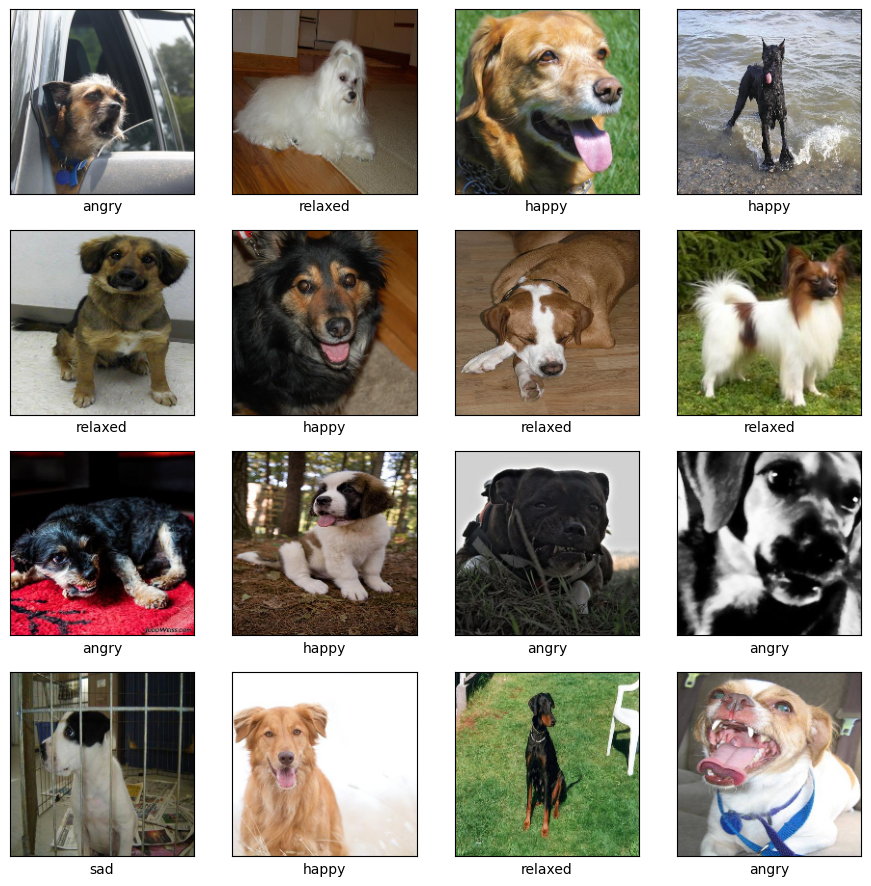

In [ ]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images) - 1)


        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">4. |</b><p style="font-size: 25px !important; display: inline-block;">Train/Test Split</p>
    </h2>
</div>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (3400, 192, 192, 3)
train labels shape: (3400, 4)

validation images shape: (600, 192, 192, 3)
validation labels shape: (600, 4)




<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">5. |</b><p style="font-size: 25px !important; display: inline-block;">CNN Model</p>
    </h2>
</div>

<img src="https://datastart.ru/blog/assets/uploads/eeugdrKO7SxHIC5MsIYVb51BWMgY4uPV.jpg" alt="">

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate images by up to 20 degrees
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train)

In [ ]:
cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=img_size))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))

# 🚀 Re-Added Convolutional Block 4
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))  # Extra dropout for deeper layers

# 🚀 Fix: Flatten before Dense layers
cnn_model.add(tf.keras.layers.Flatten())  # Converts feature maps to 1D

# Dense block (Fully connected layers)
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))

# 🚀 Fix: Move Softmax to the end (output layer)
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 96, 96, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 96, 96, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 48, 48, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 48, 48, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 24, 24, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 24, 24, 512)         │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,020,932 (80.19 MB)

 Trainable params: 21,020,932 (80.19 MB)

 Non-trainable params: 0 (0.00 B)


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">6. |</b><p style="font-size: 25px !important; display: inline-block;">Model Training</p>
    </h2>
</div>

In [ ]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras', save_best_only=True)


In [ ]:
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=25,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_callback])

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 68s 551ms/step - accuracy: 0.2502 - loss: 1.4210 - val_accuracy: 0.2267 - val_loss: 1.3868
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 394ms/step - accuracy: 0.2402 - loss: 1.3866 - val_accuracy: 0.2267 - val_loss: 1.3868
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - accuracy: 0.2504 - loss: 1.3864 - val_accuracy: 0.2267 - val_loss: 1.3867
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 508ms/step - accuracy: 0.2594 - loss: 1.3860 - val_accuracy: 0.2267 - val_loss: 1.3867
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.2704 - loss: 1.3854 - val_accuracy: 0.2617 - val_loss: 1.3869
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 53s 491ms/step - accuracy: 0.2928 - loss: 1.3788 - val_accuracy: 0.2583 - val_loss: 1.3809
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 537ms/step - accuracy: 0.3165 - loss: 1.3589 - val_accuracy: 0.3267 - val_loss: 1.3359
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 544ms/step - accuracy: 0.3363 - loss: 1


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">7. |</b><p style="font-size: 25px !important; display: inline-block;">Accuracy and Loss Plot</p>
    </h2>
</div>

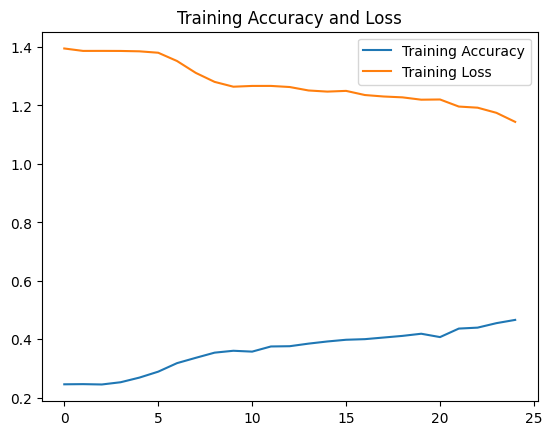

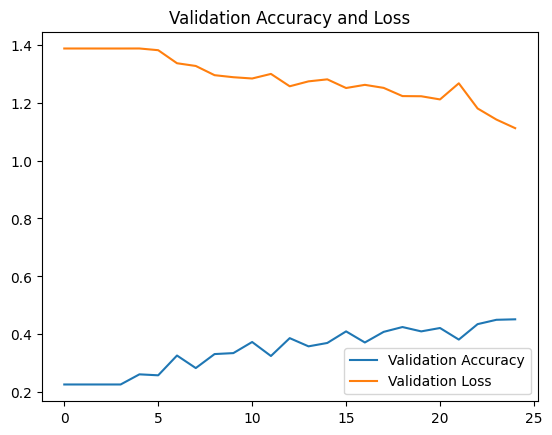

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">8. |</b><p style="font-size: 25px !important; display: inline-block;">Predictions</p>
    </h2>
</div>

In [ ]:
fig, axs = plt.subplots(7, 4, figsize=(15, 15))

i = 0
for x in range(7):
    for y in range(4):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0]

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()